In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [81]:
import os
import warnings
warnings.filterwarnings('ignore')

import math
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 50)

from pathlib import Path
import random

from plotnine import * 

from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import mean_absolute_error

from flaml import AutoML

%matplotlib inline
%config InlineBackend.figure_format='retina'

INPUT_DIR = Path('/kaggle/input/playground-series-s3e14/')

In [82]:
TARGET_NAME = 'yield'

# nested CV to ensure true out of fold metrics
N_OUTER_FOLDS = 9
N_FOLDS = 10
N_REPEATS = 10


FIRST_TIME_BUDGET = 1 #1200  # Exploration Budget for first fit
MIN_TIME_BUDGET = 1 ##10     # subseqent fit times are reduced

INCLUDE_ORIGINAL = True

RANDOM_STATE = 2112 # overture...

np.random.seed(RANDOM_STATE)


In [83]:
test_data = pd.read_csv('test.csv')
test_data['data_type'] = 0

train_data = pd.read_csv('train_combine.csv')
train_data['data_type'] = 0


features = (['MinOfLowerTRange', 'RainingDays', 'fruitmass', 'fruitset', 'seeds', 'bumbles', 'clonesize']
            +  ([] if INCLUDE_ORIGINAL else ['data_type']))

def fe(df):
    # a couple of rows seem odd 
    # probably not enough to make much of a difference
    df['RainingDays'] = np.select(
        condlist=[
            df['RainingDays'] == 26, 
            df['RainingDays'] == 33],
        choicelist= [24, 34],
        default=df['RainingDays'])
    
fe(train_data)
fe(test_data)

In [84]:
unique_targets = np.unique(train_data["yield"])
def mattop_post_process(preds):
     return np.array([min(unique_targets, key = lambda x: abs(x - pred)) for pred in preds])

In [85]:
train_data.filter(features).describe().T

,count,mean,std,min,25%,50%,75%,max
MinOfLowerTRange,16066.0,28.661988,3.195960,24.300000,27.000000,30.000000,30.000000,33.000000
RainingDays,16066.0,18.643737,11.680365,1.000000,16.000000,16.000000,24.000000,34.000000
fruitmass,16066.0,0.446525,0.037200,0.311921,0.418867,0.446570,0.474777,0.535660
fruitset,16066.0,0.502711,0.074639,0.192732,0.457833,0.506686,0.560709,0.652144
seeds,16066.0,36.162894,4.048407,22.079199,33.232449,36.047770,39.158238,46.585105
bumbles,16066.0,0.286556,0.060249,0.000000,0.250000,0.250000,0.380000,0.585000
clonesize,16066.0,19.659374,6.618134,10.000000,12.500000,25.000000,25.000000,40.000000


In [86]:
from flaml.automl.model import LGBMEstimator

# customisation to set LGB objective to L1 loss
class MyLGBM(LGBMEstimator):
    """customise objective for l1 loss"""

    def __init__(self, **config):
        super().__init__(objective="regression_l1", **config)

In [87]:
def fold_mae(y, preds, data_type):
    # evaluate against competition training data only
    return mean_absolute_error(y[data_type==0], preds[data_type==0])

def get_fi(automl, estimator_name, X, y):
    # extract permutation feature importance
    # from the model.
    
    fi = pd.DataFrame({
        'estimator_name': [],
        'Feature': [],
        'Importance': []})
    
    try:
        # ensemble - use lgbm
        est = automl.model.named_estimators_['lgbm']
        imp = permutation_importance(est, X, y)
        fi = pd.DataFrame({
            'Importance': imp.importances_mean,
            'Feature': X.columns})
    except:
        try:
            est = automl.model
            imp = permutation_importance(est, X, y)
            fi = pd.DataFrame({
                'Importance': imp.importances_mean,
                'Feature': X.columns})
        except:
            pass
    
    if len(fi) > 0:
        fi = fi.assign(estimator_name=estimator_name)
    
    return fi


class AutoMLFitter:
    # A wrap of the automl call to allow us to
    # decrease the time budget for each call
    # And keep track of the best parameters found
    
    def __init__(self, name, time_budget, estimator_list=[], best_config=None, n_folds=10):
        self.name = name
        self.time_budget = time_budget
        self.estimator_list = estimator_list
        self.best_config = best_config
        self.n_folds = n_folds

    def fit_automl(self, random_state, X, y):

        automl_settings = {
            "time_budget": self.time_budget,
            "metric": 'mae',
            "task": 'regression',
            "log_file_name": "",
            "ensemble": False,
            "eval_method": 'cv',
            "n_splits": self.n_folds,
            "seed": random_state,
            "verbose": 0,
            "estimator_list": self.estimator_list
        }

        # time budget is decreased on each fit.
        self.time_budget //= 1.5
        if self.time_budget < MIN_TIME_BUDGET:
            self.time_budget = MIN_TIME_BUDGET

        automl = AutoML()
        automl.add_learner(learner_name='my_lgbm', learner_class=MyLGBM)
        automl_settings["estimator_list"] = ['my_lgbm' ]  # change the estimator list
        
        automl.fit(X, y, starting_points=self.best_config, **automl_settings)
        self.best_config = automl.best_config_per_estimator

        return automl

In [88]:
def fit_nested_automl(model_fitters, random_state, train_data, test_data, features):
                               
    k_fold = KFold(n_splits=N_OUTER_FOLDS, random_state=random_state, shuffle=True)
    
    fast_fis = []
    oof_metrics = []
    test_preds = np.zeros(len(test_data))
    oof_preds = np.zeros(len(train_data))
    
    print('OOF Metric: ', end='')
    for train_index, test_index in k_fold.split(train_data, train_data[TARGET_NAME]):
        tr, vl = train_data.loc[train_index], train_data.loc[test_index]
        
        # for each model:
        oof_pred = np.zeros(len(vl))
        test_pred = np.zeros(len(test_data))
        best_loss = 0
        
        for model_fitter in model_fitters:
            
            automl = model_fitter.fit_automl(
                random_state, 
                tr.filter(features), 
                tr[TARGET_NAME].values)
        
            oof_pred  += automl.predict(vl.filter(features)) / len(model_fitters)
            test_pred += automl.predict(test_data.filter(features)) / len(model_fitters)
            best_loss += automl.best_loss / (len(model_fitters))
        
            fast_fi =  get_fi(automl, model_fitter.name, vl.filter(features), vl[TARGET_NAME])
            fast_fis.append(fast_fi)
        
        oof_metric = fold_mae(
            vl[TARGET_NAME].values, 
            oof_pred, 
            vl['data_type'].values)
        
        print(f'{oof_metric:4.1f}', end=' ')
        
        oof_preds[test_index] += oof_pred
        test_preds += test_pred / N_OUTER_FOLDS
        fast_fis.append(fast_fi)
        oof_metrics.append(oof_metric)

    return oof_preds, test_preds, fast_fis, oof_metrics


def fit(model_fitters, train_data, test_data, features):
    test_preds = np.zeros(len(test_data))
    oof_preds = np.zeros(len(train_data))
    oof_metrics = []
    oof_fold_metrics = []
    fast_fis = []
    for i in range(N_REPEATS): 
        # fit
        oof_pred, test_pred, fast_fi, oof_fold_metric = fit_nested_automl(
            model_fitters,
            RANDOM_STATE + i,
            train_data.sample(frac=1),
            test_data,
            features)

        oof_metric = fold_mae(
            train_data[TARGET_NAME].values, 
            oof_pred, 
            train_data['data_type'].values)
        
        oof_metric_pp = fold_mae(
            train_data[TARGET_NAME].values, 
            mattop_post_process(oof_pred), 
            train_data['data_type'].values)

        test_preds += (test_pred) / N_REPEATS
        oof_preds += (oof_pred) / N_REPEATS

        oof_fold_metrics.extend(oof_fold_metric)
        fast_fis.extend(fast_fi)

        print(f'| Repeat {i}: {oof_metric:4.1f} mattop postprocessing {oof_metric_pp:4.1f}')
        
    return oof_preds, test_preds, oof_fold_metrics, fast_fis

In [89]:
tr = train_data.sample(frac=1, random_state=RANDOM_STATE)

model_fitter = AutoMLFitter(
    name='model',
    time_budget= FIRST_TIME_BUDGET, 
    n_folds=5) # nested CV: 8/9 * 9/10 = 80%, equivalent to 5 folds

# here's one I made earlier:
# running the fitter with a longer budget will discover these 
# hyperparameters:
model_fitter.best_config = {
    'my_lgbm': {'n_estimators': 265, 'num_leaves': 93, 'min_child_samples': 20, 
                'learning_rate': 0.05533790147941807, 'log_max_bin': 10, 
                'colsample_bytree': 0.8809128870084636, 'reg_alpha': 0.0009765625, 
                'reg_lambda': 0.015589408048174165}}

model_fitter.fit_automl(
    RANDOM_STATE, 
    tr.filter(features), 
    tr[TARGET_NAME].values)

model_fitter.time_budget = MIN_TIME_BUDGET
model_fitter.n_folds = N_FOLDS

print(model_fitter.best_config)

models = [model_fitter]
# model fit & output
oof_preds, test_preds, oof_fold_metrics, fast_fis = fit(models, train_data, test_data, features)

{'my_lgbm': {'n_estimators': 265, 'num_leaves': 93, 'min_child_samples': 20, 'learning_rate': 0.05533790147941807, 'log_max_bin': 10, 'colsample_bytree': 0.8809128870084636, 'reg_alpha': 0.0009765625, 'reg_lambda': 0.01558940804817417}}
OOF Metric: 344.2 320.8 318.4 319.0 307.3 328.3 335.2 344.1 340.5 | Repeat 0: 328.7 mattop postprocessing 328.5
OOF Metric: 338.9 326.4 327.2 322.8 346.1 331.3 330.9 333.3 306.7 | Repeat 1: 329.3 mattop postprocessing 329.2
OOF Metric: 333.8 336.1 328.9 325.4 337.3 322.6 330.9 319.4 322.2 | Repeat 2: 328.5 mattop postprocessing 328.4
OOF Metric: 315.2 311.9 330.5 341.2 324.3 336.9 325.0 339.6 333.1 | Repeat 3: 328.6 mattop postprocessing 328.4
OOF Metric: 322.6 334.3 324.7 325.6 319.5 335.6 329.3 343.9 323.8 | Repeat 4: 328.8 mattop postprocessing 328.7
OOF Metric: 340.1 326.7 344.7 315.6 329.0 336.2 333.1 316.9 318.8 | Repeat 5: 329.0 mattop postprocessing 328.9
OOF Metric: 305.4 333.0 329.9 323.6 334.5 343.2 332.6 329.6 326.3 | Repeat 6: 328.7 mattop 

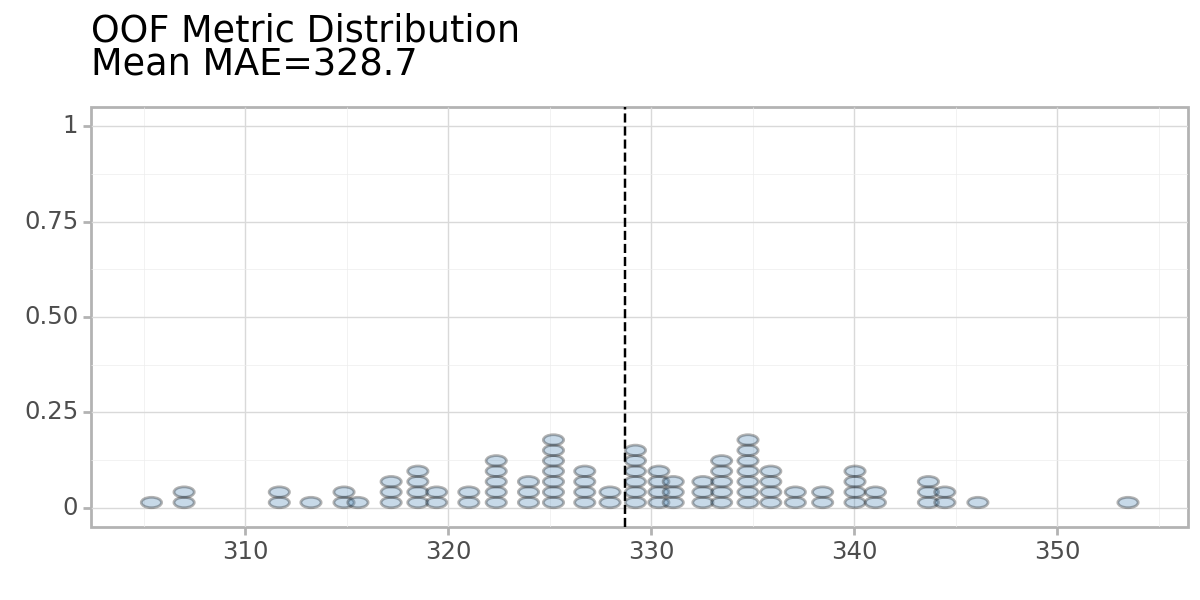

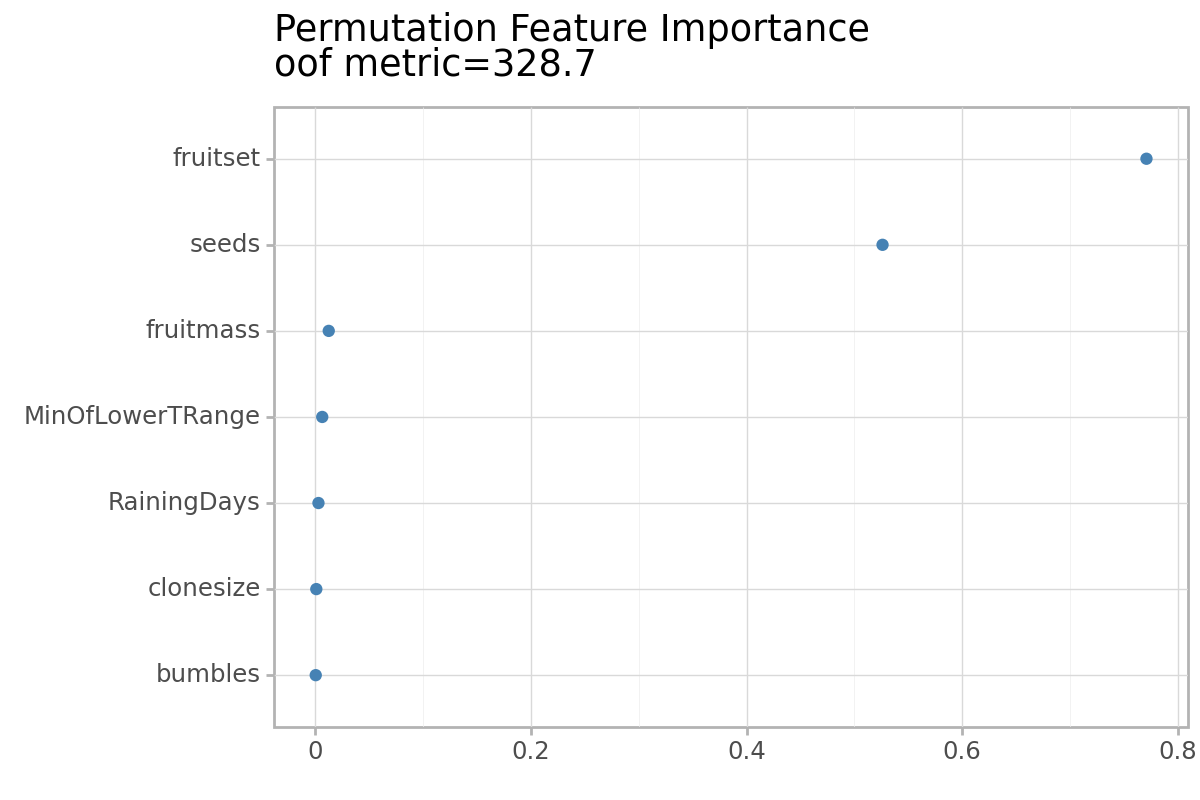


            Feature  mean_imp   std_imp
2           bumbles  0.000416  0.000354
3         clonesize  0.000944  0.000668
1       RainingDays  0.002951  0.001030
0  MinOfLowerTRange  0.006449  0.001534
4         fruitmass  0.012479  0.002690
6             seeds  0.526108  0.031267
5          fruitset  0.770888  0.044763


In [90]:
df_metrics = pd.DataFrame({'oof': oof_fold_metrics})
print(ggplot(df_metrics, aes(x='oof'))
    + theme_light()
    + theme(figure_size=(6, 3))
    + geom_dotplot(alpha=0.3, binwidth = 1, fill='SteelBlue')
    + geom_vline(xintercept=np.mean(oof_fold_metrics), linetype='dashed')
    + labs(
        y = '', x='', 
        title = f'OOF Metric Distribution\nMean MAE={np.mean(oof_fold_metrics):4.1f}'))

df_importance = pd.concat(fast_fis).sort_values(['Importance'])
if len(df_importance) > 0:
    df_importance_mean = (
        df_importance
        .groupby(['Feature'], as_index=False)
        .agg(mean_imp=('Importance', 'mean'), std_imp=('Importance', 'std'))
        .sort_values(['mean_imp']))

    feature_list = df_importance_mean['Feature'].tolist()
    feature_cat  = pd.Categorical(df_importance_mean['Feature'], categories=feature_list) #[::-1])
    
    df_importance_mean = (df_importance_mean
        .assign(
            feature_cat = feature_cat,
            mean_imp_min = lambda x: x['mean_imp'] - 2 * x['std_imp'],
            mean_imp_max = lambda x: x['mean_imp'] + 2 * x['std_imp']))
    
    df_importance = df_importance.merge(df_importance_mean.filter(['Feature', 'feature_cat']))

    print(ggplot(df_importance, aes(y='feature_cat', x='Importance')) 
        + theme_light()
        + theme(figure_size=(6, 4))
        #+ geom_jitter(alpha=0.2, size=0.5, height=0.1)
        + geom_point(mapping=aes(x='mean_imp'), colour='SteelBlue', data=df_importance_mean) 
        #+ geom_errorbarh(
        #    mapping=aes(x='mean_imp', xmin='mean_imp_min', xmax='mean_imp_max'), 
        #    alpha=0.5,  data=df_importance_mean)  
        + labs(
            y = '', x='', 
            title = (f'Permutation Feature Importance\n'
                f'oof metric={np.mean(oof_fold_metrics):4.1f}'))
        #+ facet_wrap('estimator_name', ncol=2)
         )
    
if len(df_importance) > 0:
    print(df_importance_mean.filter(['Feature', 'mean_imp', 'std_imp']).head(20))

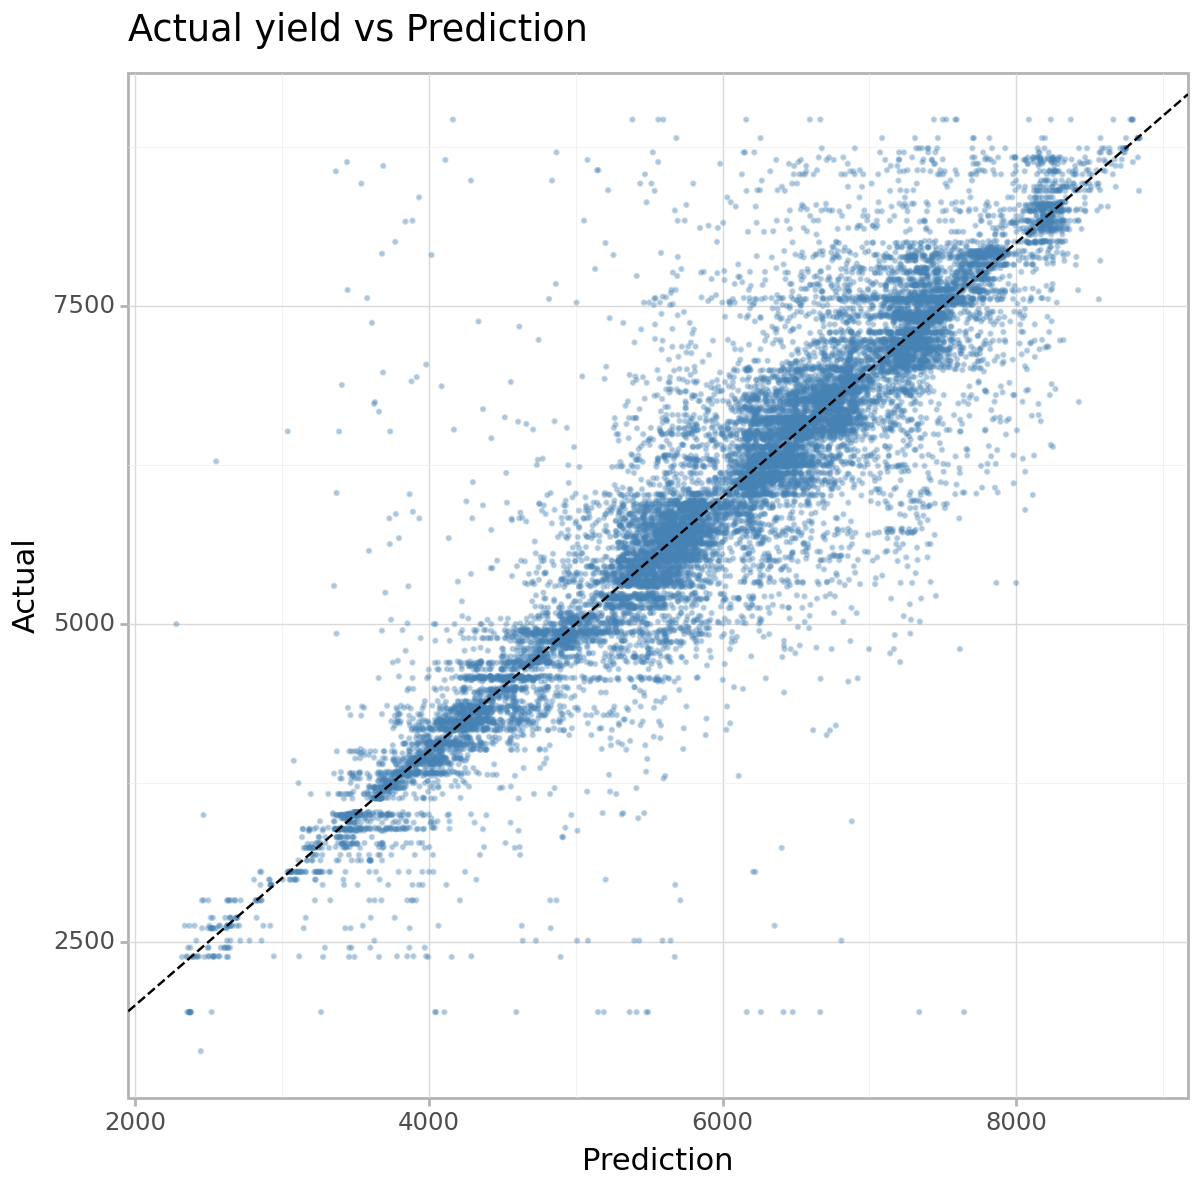

In [91]:
pred_data = train_data.assign(pred=oof_preds)
print(ggplot(pred_data, aes(x='pred', y=TARGET_NAME))
    + theme_light()
    + theme(figure_size=(6, 6))
    + geom_point(alpha=0.3, size=0.3, colour='SteelBlue')
    + geom_abline(intercept=0, slope=1, linetype='dashed')
    + labs(y='Actual', x='Prediction', title=f'Actual {TARGET_NAME} vs Prediction'))

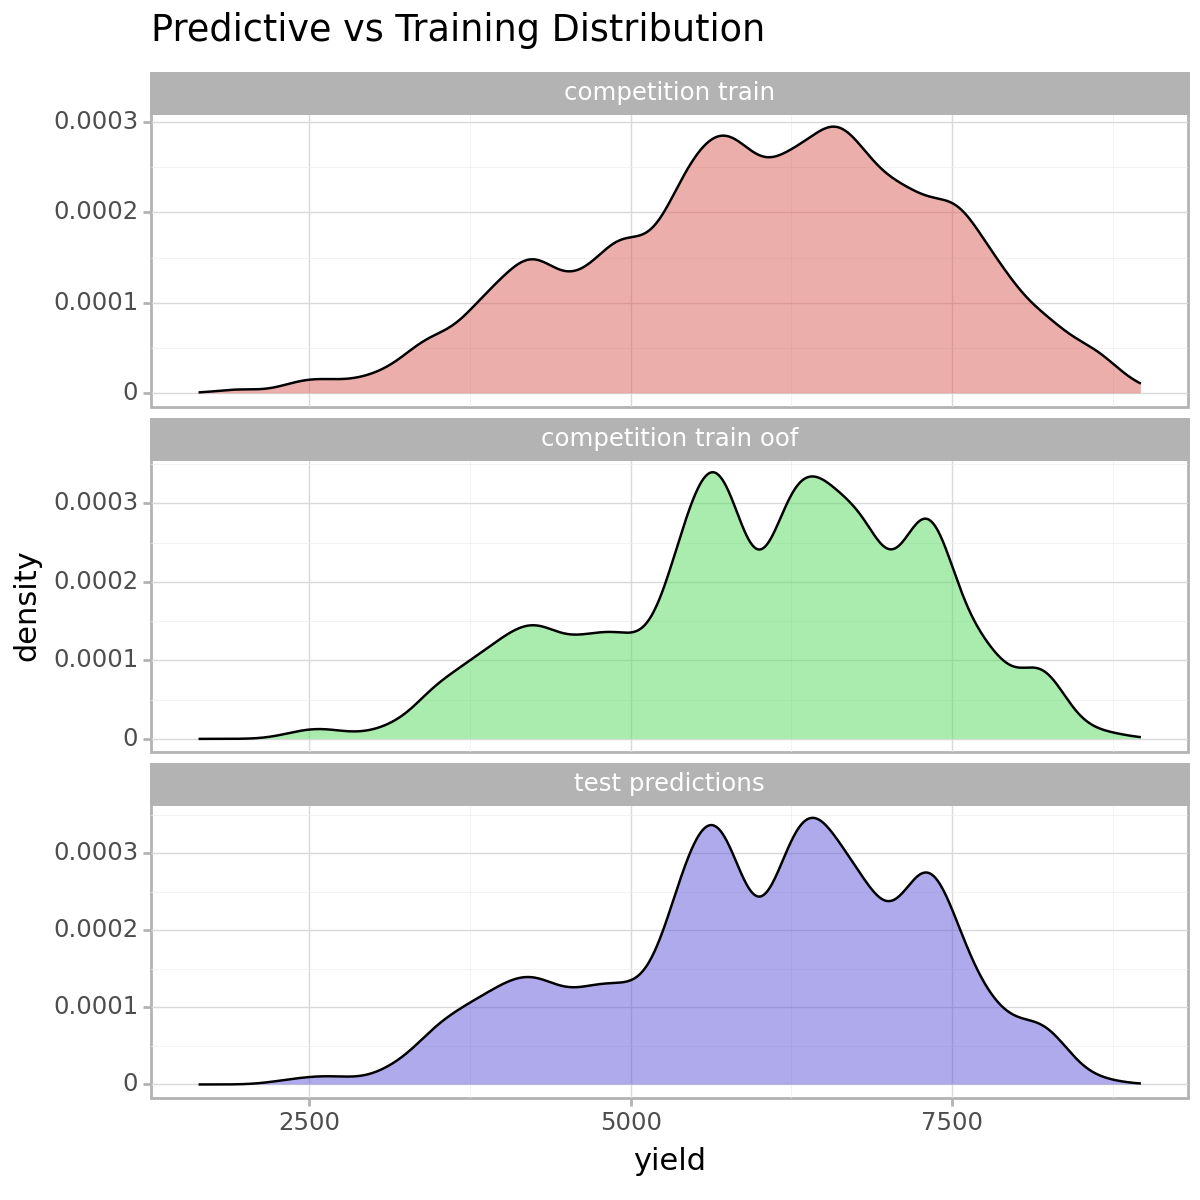

In [92]:
df_dist = pd.concat([
    (train_data
        .assign(
            source=lambda x: 
                np.where(x['data_type'] == 0, 'competition train', 'original train'))
        .filter([TARGET_NAME, 'source'])),
    (test_data
        .filter(['Strength'])
        .assign(**{TARGET_NAME: test_preds})
        .assign(source='test predictions')),
    (pred_data
        .filter(['pred'])
        .rename(columns={'pred': TARGET_NAME})
        .assign(source='competition train oof'))])


print(ggplot(df_dist, aes(x=TARGET_NAME, fill='source'))
    + theme_light()
    + theme(
        figure_size=(6, 6),
        legend_position='none')
    + geom_density(alpha=0.5) 
    + facet_wrap('source', ncol=1, scales='free_y')
    + labs(title='Predictive vs Training Distribution'))

## Part 2

In [93]:
SEED = 1984
target = "yield"

from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

class PLSRegressionWrapper(PLSRegression):
    def transform(self, X):
        return super().transform(X)
    def fit_transform(self, X, Y):
        return self.fit(X,Y).transform(X)

import lightgbm as lgb

In [94]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train_combine.csv')

train.loc[train["RainingDays"]==26, "RainingDays"] = 24
test.loc[test["RainingDays"]==33, "RainingDays"] = 34

for df in [train, test]:
    df.loc[df["MaxOfUpperTRange"].isin([71.9, 79, 89]), "MaxOfUpperTRange"] = 86

for df in [train, test]:
    display(df["RainingDays"].value_counts())
    display(df["MaxOfUpperTRange"].value_counts())

16.00    4555
24.00    4026
1.00     3713
34.00    3708
3.77       64
Name: RainingDays, dtype: int64

86.0    4417
77.4    3976
94.6    3928
69.7    3745
Name: MaxOfUpperTRange, dtype: int64

16.00    2831
24.00    2534
1.00     2438
34.00    2352
3.77       39
Name: RainingDays, dtype: int64

86.0    2730
77.4    2594
94.6    2532
69.7    2338
Name: MaxOfUpperTRange, dtype: int64

In [95]:
class MyFeaturesEngineering(BaseEstimator, TransformerMixin):
    
    def __init__(self, verbose = False, 
                 feats_for_pca = ["seeds", "fruitmass", "fruitset"], 
                 feats_for_pls = ["seeds", "fruitmass", "fruitset"]):
        
        self.verbose = verbose
        
        self.pca_components = len(feats_for_pca)
        self.feats_for_pca = feats_for_pca
        
        self.pls_components = len(feats_for_pls)
        self.feats_for_pls = feats_for_pls
        

    def fit(self, x, y=None):
        
        self.pipe_pca = make_pipeline(StandardScaler(), PCA(n_components = self.pca_components))
        self.pipe_pca.fit(x[self.feats_for_pca])
        
        self.pipe_pls = make_pipeline(StandardScaler(), PLSRegressionWrapper(n_components = self.pls_components))
        self.pipe_pls.fit(x[self.feats_for_pls], x[target])
        
        return self
    
    def transform(self, x, y=None):
        
        df = x.copy()
        
        pca_cols = [f"pca_{i}" for i in range(self.pca_components)]
        df[pca_cols] = self.pipe_pca.transform(df[self.feats_for_pca])
        
        pls_cols = [f"pls_{i}" for i in range(self.pls_components)]
        df[pls_cols] = self.pipe_pls.transform(df[self.feats_for_pls])
        
        return df

In [96]:
def fit_lgbm(params={}, features = None, use_original = False,
            n_splits = 5, seed = SEED, verbose = False,
             feats_for_pca = ["seeds", "fruitmass", "fruitset"], 
                 feats_for_pls = ["seeds", "fruitmass", "fruitset"]
            ):
    
    if features is None:
        features = test.columns
    best_iteration, val_score, trn_score = [], [], []
    eval_result={}
    callbacks = [lgb.early_stopping(100), lgb.record_evaluation(eval_result)]
    if verbose:
        callbacks.append(lgb.log_evaluation(200))
        
    oof = pd.Series(0, index=train.index)
    y_pred = pd.Series(0, index=test.index)
   
    # CV loop...
    folds = KFold(n_splits = n_splits, shuffle = True, random_state = seed)
    for fold, (trn_idx, val_idx) in enumerate(folds.split(train, train[target])):
        
        fe = MyFeaturesEngineering(feats_for_pca = feats_for_pca, feats_for_pls = feats_for_pls)
        if use_original: # Concat train and origin datasets for fitting
            X_trn = fe.fit_transform(pd.concat([train.loc[trn_idx]], axis=0))[features]
            y_trn = pd.concat([train.loc[trn_idx]], axis=0)[target]
        else:            # and don't
            X_trn = fe.fit_transform(train.loc[trn_idx])[features]
            y_trn = train.loc[trn_idx, target]

        # Don't use original dataset to fit
        X_val, y_val = fe.transform(train.loc[val_idx])[features], train.loc[val_idx, target]
        
        X_pred = fe.transform(test)[features]
        
        dtrn = lgb.Dataset(X_trn, label = y_trn) 
        dval = lgb.Dataset(X_val, label = y_val)

        # TRAIN MODEL        
        model = lgb.train(params, dtrn, num_boost_round = 2000, valid_sets = dval, callbacks = callbacks)#, categorical_feature = "auto")
        best_iteration.append(model.best_iteration)
        
        # Results, score
        oof.loc[val_idx] = model.predict(X_val, num_iteration = best_iteration[fold])
        y_pred += model.predict(X_pred, num_iteration = best_iteration[fold]) / n_splits
        val_score.append(mean_absolute_error(y_val, oof.loc[val_idx]))
        trn_score.append(mean_absolute_error(y_trn, model.predict(X_trn)))
        if verbose:
            print(f'Fold {fold + 1} - Valid : {val_score[fold]:.5f} - Train : {trn_score[fold]:.5f} - Best it. : {best_iteration[fold]:4}')
        
    # End CV Loop
    print(f"OOF MAE : {mean_absolute_error(train[target], oof):.5f} - Mean MAE {np.mean(val_score):.5f} - Overfeat {np.mean(trn_score) - np.mean(val_score):.5f} - Std {np.std(val_score):.5f}")
    
    return {"oof":oof, "oof_score":mean_absolute_error(train[target], oof), "overfeat":np.mean(trn_score) - np.mean(val_score),
           "best_iteration":best_iteration, "y_pred":y_pred}

In [97]:
params = {
    'objective':'regression_l1',
#    'num_leaves': 31, # Default : 31
#    'min_child_samples': 20, # Default : 20
    'learning_rate': 0.04, 
    'max_bin': 1000, # Default : 255
    'colsample_bytree': .8, # Default : 1
    'subsample': .7, # Default : 1
    'bagging_freq': 1,
    'random_state': SEED,
    'verbose':-1,
}

res1 = fit_lgbm(params, n_splits = 10, seed = SEED, verbose = True, use_original = True, 
               feats_for_pca = ['fruitset', 'seeds', 'fruitmass'], 
              features=["pca_0", "pca_1", 'RainingDays', 'fruitmass', 'MaxOfUpperTRange', 'fruitset', 'seeds'])


print(f"OOF MAE : {res1['oof_score']:.5f}")

Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 323.456
[400]	valid_0's l1: 321.533
[600]	valid_0's l1: 320.67
[800]	valid_0's l1: 319.991
Early stopping, best iteration is:
[763]	valid_0's l1: 319.865
Fold 1 - Valid : 319.86516 - Train : 284.86507 - Best it. :  763
[200]	valid_0's l1: 318.268
[400]	valid_0's l1: 317.027
Early stopping, best iteration is:
[386]	valid_0's l1: 316.912
Fold 2 - Valid : 316.91169 - Train : 300.77582 - Best it. :  386
[200]	valid_0's l1: 322.208
[400]	valid_0's l1: 321.469
Early stopping, best iteration is:
[386]	valid_0's l1: 316.912
Fold 3 - Valid : 321.43106 - Train : 299.60734 - Best it. :  386
[200]	valid_0's l1: 319.656
[400]	valid_0's l1: 318.126
Early stopping, best iteration is:
[386]	valid_0's l1: 316.912
Fold 4 - Valid : 318.23056 - Train : 300.22258 - Best it. :  386
[200]	valid_0's l1: 329.01
[400]	valid_0's l1: 327.492
Early stopping, best iteration is:
[386]	valid_0's l1: 316.912
Fold 5 - Valid : 327.65322 - 

In [98]:
res2 = fit_lgbm(params, n_splits = 10, seed = SEED, verbose = True, use_original = True, 
               feats_for_pca = ['fruitset', 'seeds', 'fruitmass'], feats_for_pls = ['fruitset', 'seeds'], 
              features=["pls_0", "pca_0", "pca_1", 'RainingDays', 'fruitmass', 'MaxOfUpperTRange', 'fruitset', 'seeds'])

Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 323.83
[400]	valid_0's l1: 321.877
[600]	valid_0's l1: 320.738
[800]	valid_0's l1: 320.345
Early stopping, best iteration is:
[896]	valid_0's l1: 319.956
Fold 1 - Valid : 319.95569 - Train : 280.20397 - Best it. :  896
[200]	valid_0's l1: 319.707
[400]	valid_0's l1: 317.662
Early stopping, best iteration is:
[434]	valid_0's l1: 317.295
Fold 2 - Valid : 317.29484 - Train : 298.16613 - Best it. :  434
[200]	valid_0's l1: 322.655
[400]	valid_0's l1: 322.314
Early stopping, best iteration is:
[434]	valid_0's l1: 317.295
Fold 3 - Valid : 322.14386 - Train : 297.00207 - Best it. :  434
[200]	valid_0's l1: 319.613
[400]	valid_0's l1: 318.01
Early stopping, best iteration is:
[434]	valid_0's l1: 317.295
Fold 4 - Valid : 317.75303 - Train : 297.58485 - Best it. :  434
[200]	valid_0's l1: 331.382
[400]	valid_0's l1: 329.588
Early stopping, best iteration is:
[434]	valid_0's l1: 317.295
Fold 5 - Valid : 329.52259 - 

In [131]:
!pip uninstall sklego
!pip install sklego


^C


In [132]:
# from sklego.linear_model import LADRegression # Least Absolute Deviation Regression
from sklearn.linear_model import HuberRegressor

from sklearn.linear_model import Ridge

import matplotlib.pyplot as plt

In [133]:
oofs = pd.DataFrame(index=train.index)
oofs = pd.concat([oofs, 
                  pd.Series(oof_preds[:train.shape[0]], index=train.index), 
                  res1["oof"], 
                  res2["oof"]], axis=1)
oofs.columns=["Patrick", "Alex1", "Alex2"]

preds = pd.DataFrame(index=test.index)
preds = pd.concat([preds, 
                  pd.Series(test_preds, index=test.index), 
                  res1["y_pred"], 
                  res2["y_pred"]], axis=1)
preds.columns=["Patrick", "Alex1", "Alex2"]
display(oofs)
display(preds)

,Patrick,Alex1,Alex2
0,4527.103410,4612.505665,4611.496051
1,4988.082690,4974.560136,4890.366478
2,6645.922260,6700.832566,6715.220690
3,6916.339857,6846.530554,6851.149218
4,7135.967953,7329.212708,7305.854232
...,...,...,...
16061,5694.846309,5643.263803,5585.349020
16062,3557.443064,3545.224723,3522.070387
16063,4345.307250,4285.470920,4315.383188
16064,4168.880413,4164.051154,4167.116232


,Patrick,Alex1,Alex2
0,4313.679394,4311.764402,4314.002261
1,5871.246687,5880.830044,5910.318874
2,7276.054895,7228.027659,7239.348005
3,4496.031041,4625.653047,4640.513433
4,3840.997895,3838.067443,3833.082667
...,...,...,...
10189,5406.093164,5433.126773,5426.168981
10190,5604.987792,5618.513697,5630.414170
10191,6489.611144,6494.402680,6486.005887
10192,4419.877681,4421.620954,4406.392102


In [134]:
print(f"MAE with mean of 3 OOFS predictions : {mean_absolute_error(train[target], oofs.mean(axis=1))}")

MAE with mean of 3 OOFS predictions : 326.7465408292802


In [135]:
ridge_blend = Ridge(positive = True)
ridge_blend.fit(oofs, train[target])
print(f"MAE with Ridge Regression of 3 OOFS predictions : {mean_absolute_error(train[target], ridge_blend.predict(oofs))}\n\nCoefficients :")
display(pd.Series(ridge_blend.coef_.round(2), oofs.columns, name='weight'))

MAE with Ridge Regression of 3 OOFS predictions : 329.0662983220654

Coefficients :


Patrick    0.76
Alex1      0.20
Alex2      0.02
Name: weight, dtype: float64

In [137]:
LADRegression_blend = HuberRegressor()
LADRegression_blend.fit(oofs, train[target])
print(f"MAE with LAD Regression of 3 OOFS predictions : {mean_absolute_error(train[target], LADRegression_blend.predict(oofs))}\n\nCoefficients :")
display(pd.Series(LADRegression_blend.coef_.round(2), oofs.columns, name='weight'))

MAE with LAD Regression of 3 OOFS predictions : 326.15254956965225

Coefficients :


Patrick    0.65
Alex1      0.26
Alex2      0.09
Name: weight, dtype: float64

In [138]:
result_df = pd.Series([
    mean_absolute_error(train[target], oofs["Patrick"]),
    mean_absolute_error(train[target], oofs["Alex1"]),
    mean_absolute_error(train[target], oofs["Alex2"]),
    mean_absolute_error(train[target], oofs.mean(axis=1)),
    mean_absolute_error(train[target], ridge_blend.predict(oofs)),
    mean_absolute_error(train[target], LADRegression_blend.predict(oofs)),
    ], index = ["Patrick", "Alex1", "Alex2", "Blend_Mean", "Blend_Ridge", "Blend_LAD"], name="MAE")
result_df

Patrick        326.628295
Alex1          328.624666
Alex2          329.108366
Blend_Mean     326.746541
Blend_Ridge    329.066298
Blend_LAD      326.152550
Name: MAE, dtype: float64

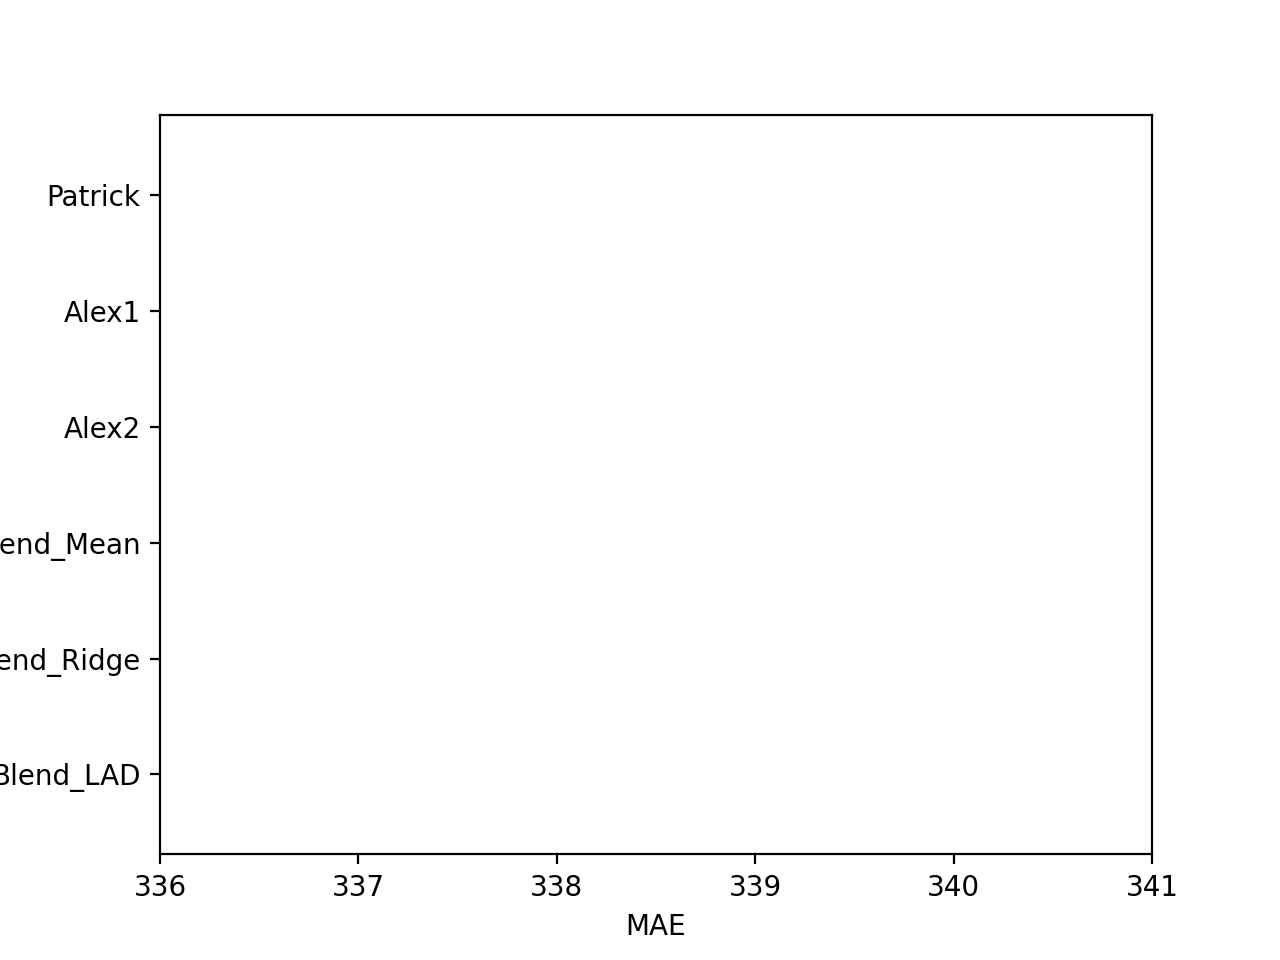

In [139]:
bars = plt.barh(result_df.index, result_df, color=["yellow", "yellow", "yellow", "brown", "brown", "green"])
plt.gca().bar_label(bars, fmt='%.2f')
plt.gca().invert_yaxis()
plt.yticks(np.arange(len(result_df)), result_df.index)
plt.xlabel('MAE')
plt.xlim(336, 341);

In [148]:
column1 = test_data['id']
final_predicted = LADRegression_blend.predict(preds)
print(final_predicted)
column1 = test_data['id']
column2 = list(final_predicted)
dataset=pd.DataFrame({'id':column1,'yield':column2})
dataset.to_csv('submission.csv',index=False)

[4312.74451057 5877.53282753 7260.80571926 ... 6490.96269595 4418.67619056
 7196.96206931]
